## 0. Imports

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import glob
from uqdd import DEVICE, FIGS_DIR, MODELS_DIR
# from uqdd.utils import get_config
from uqdd.utils import load_df, create_logger
from uqdd.models.utils_models import load_model, get_model_config
from uqdd.models.baseline import BaselineDNN
from uqdd.models.ensemble import EnsembleDNN
from uqdd.models.mcdropout import mc_predict
from uqdd.models.evidential import EvidentialDNN, ev_predict

# METRICS
from uqdd.models.utils_train import predict, evaluate_predictions, recalibrate_model, get_dataloader
from uqdd.models.utils_metrics import MetricsTable, process_preds, create_df_preds

# # Importing models and their predict functions
# from uqdd.models.utils_train import predict # for ensemble
import matplotlib.pyplot as plt
import ast
# Turn off interactive mode
plt.ioff()

## 1. Predefined variables and Paths

In [4]:
data_name = 'papyrus'
activity_type = 'xc50'
type_n_targets = 'all'
project_name = '2024-06-25-all-models-100'
project_out_name = f'reassess-{project_name}'
data_specific_path = f'{data_name}/{activity_type}/{type_n_targets}'
# DESCRIPTORS
descriptor_protein='ankh-large'
descriptor_chemical='ecfp2048'
prot_input_dim=1536
chem_input_dim=2048

# PATHS
preds_dirpath = f'/users/home/bkhalil/Repos/uqdd/uqdd/data/predictions/{data_specific_path}/'
models_dir = f'/users/home/bkhalil/Repos/uqdd/uqdd/models/saved_models/{data_specific_path}/'
runs_path = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/{project_name}/runs.csv'

# FIGS OUT PATH 
figs_out_path = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/{project_out_name}/'

# check if the runs_path exists
if not os.path.exists(runs_path):
    raise FileNotFoundError(f"File {runs_path} not found")

# create figs_out_path if it does not exist
os.makedirs(figs_out_path, exist_ok=True)

logger = create_logger(
    name="reassess",
    file_level="debug",
    stream_level="debug",
)

2024-07-05 02:01:15:DEBUG:reassess:Logger reassess initialized:1125960
2024-07-05 02:01:15:DEBUG:reassess:Logger reassess initialized:1125960


## 2. Helper functions

In [5]:
# Function to convert string representation of list to actual list of integers
def convert_to_list(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val

# RUNS preprocessing
def preprocess_runs(
        runs_path,
        models_dir=MODELS_DIR,
        data_name='papyrus',
        activity_type='xc50',
        descriptor_protein='ankh-large',
        descriptor_chemical='ecfp2048',
        data_specific_path='papyrus/xc50/all',
        prot_input_dim=1536,
        chem_input_dim=2048,
):
    # Load csv runs and model names file
    runs_df = load_df(
        runs_path, 
        converters={
            'chem_layers': convert_to_list, 
            'prot_layers': convert_to_list, 
            'regressor_layers': convert_to_list
        })
    runs_df.rename(columns={'Name': 'run_name'}, inplace=True)
    
    # DEALING WITH MODEL_NAME IF DOESN'T EXIST
    runs_df['model_name'] = runs_df.apply(
    lambda row: f"{data_name}_{activity_type}_{row['model_type']}_{row['split_type']}_{descriptor_protein}_{descriptor_chemical}_{row['run_name']}"
    if pd.isna(row['model_name']) else row['model_name'], axis=1)
    
    i = 1
    # Update and match model_name with model saved files
    for index, row in runs_df.iterrows():
        model_name = row['model_name']
        model_file_pattern = os.path.join(models_dir, f"*{model_name}.pt")
        model_files = glob.glob(model_file_pattern)
        if model_files:
            model_file_path = model_files[0]
            model_name = os.path.basename(model_file_path).replace('.pt', '')
            # print(model_name)
            runs_df.at[index, 'model_name'] = model_name
            # add model_file_path to the runs_df
            runs_df.at[index, 'model_path'] = model_file_path
        else:
            print(f"{i} Model file(s) not found for {model_name} \n with pattern {model_file_pattern}")
            runs_df.at[index, 'model_path'] = ''
            i+=1
            
    # Ensure rest of variables set correctly across the runs
    runs_df['data_name'] = data_name
    runs_df['activity_type'] = activity_type
    runs_df['descriptor_protein'] = descriptor_protein
    runs_df['descriptor_chemical'] = descriptor_chemical
    runs_df['chem_input_dim'] = chem_input_dim
    runs_df['prot_input_dim'] = prot_input_dim
    runs_df['data_specific_path'] = data_specific_path
    
    return runs_df

# Get model class and predict function

def get_model_class(model_type: str):
    if model_type.lower() in ['baseline', 'mcdropout']:
        model_class = BaselineDNN
    elif model_type.lower() == 'ensemble':
        model_class = EnsembleDNN
    elif model_type.lower() == 'evidential':
        model_class = EvidentialDNN
    else:
        raise ValueError(f"Model type {model_type} not recognized")
    return model_class

def get_predict_fn(model_type: str):
    if model_type.lower() == 'mcdropout':
        predict_fn = mc_predict
        predict_kwargs = {"aleatoric": True, "num_mc_samples": 100}
        
    elif model_type.lower() in ['ensemble', 'baseline']:
        predict_fn = predict
        predict_kwargs = {}
        
    elif model_type.lower() == 'evidential':
        predict_fn = ev_predict
        predict_kwargs = {}
    else:
        raise ValueError(f"Model type {model_type} not recognized")
    return predict_fn, predict_kwargs


def get_preds(model, dataloaders, model_type, subset='test'):
    predict_fn, predict_kwargs = get_predict_fn(model_type)
    preds_res = predict_fn(model, dataloaders[subset], device=DEVICE, **predict_kwargs)
    if model_type == 'evidential':
        preds, labels, alea_vars, epi_vars = preds_res
    else:
        preds, labels, alea_vars = preds_res
        epi_vars = None
        
    return preds, labels, alea_vars, epi_vars


def pkl_preds_export(preds, labels, alea_vars, epi_vars, outpath):
    # preds, labels = predict(model, dataloaders["test"], return_targets=True)
    y_true, y_pred, y_eps, y_err, y_alea = process_preds(
        preds, labels, alea_vars, epi_vars, None
    )
    df = create_df_preds(
        y_true,
        y_pred,
        y_alea,  # y_std,
        y_err,
        y_eps,  # y_alea,
        export=False,
        logger=logger,
    )
    
    df.to_pickle(os.path.join(outpath,"preds.pkl"))
    return df

def reassess_metrics(
        runs_df,
        figs_out_path,
        csv_out_path,
        project_out_name,
        logger,
):
    # Reversing rows
    runs_df = runs_df[::-1]
    # Reassessing metrics and recalibration of the pretrained models
    # iterate but reverse the order of iter
    
    for index, row in runs_df.iterrows():
        # if index !=1: # Debugging
        #     continue
        model_path = row["model_path"]
        model_name = row["model_name"]

        # print(type(model_path))
        rowkwargs = row.to_dict()
        # popping the model_type
        model_type = rowkwargs.pop("model_type")

        if model_path:
            model_fig_out_path = os.path.join(figs_out_path, model_name)
            if os.path.exists(model_fig_out_path):
                print(f"Model {model_name} already reassessed")
                continue
            config = get_model_config(model_type=model_type, **rowkwargs)
            model_class = get_model_class(model_type)
            model = load_model(model_class, model_path, config=config).to(DEVICE)

            # Getting DataLoaders
            dataloaders = get_dataloader(config, device=DEVICE, logger=logger)

            # RePredict and Evaluate preds
            preds, labels, alea_vars, epi_vars = get_preds(
                model, dataloaders, model_type, subset="test"
            )
            df = pkl_preds_export(preds, labels, alea_vars, epi_vars, model_fig_out_path)

            # Calculate the metrics
            metrics, plots, uct_logger = evaluate_predictions(
                config,
                preds,
                labels,
                alea_vars,
                model_type,
                logger,
                epi_vars=epi_vars,
                wandb_push=False,
                run_name=config["run_name"],
                project_name=project_out_name,  # for the csv file
                figpath=model_fig_out_path,
                export_preds=False,
                verbose=False,
                csv_path=csv_out_path,
            )

            # Recalibrate model
            preds_val, labels_val, alea_vars_val, epi_vars_val = get_preds(
                model, dataloaders, model_type, subset="val"
            )

            iso_recal_model = recalibrate_model(
                preds_val,
                labels_val,
                alea_vars_val,
                preds,
                labels,
                alea_vars,
                config=config,
                epi_val=epi_vars_val,
                epi_test=epi_vars,
                uct_logger=uct_logger,
                figpath=model_fig_out_path,
            )

            # Log the metrics to the CSV file
            uct_logger.csv_log()

In [6]:
# Load runs_df and preprocess it
runs_df = preprocess_runs(
    runs_path,
    models_dir=models_dir,
    data_name=data_name,
    activity_type=activity_type,
    descriptor_protein=descriptor_protein,
    descriptor_chemical=descriptor_chemical,
    data_specific_path=data_specific_path,
    prot_input_dim=prot_input_dim,
    chem_input_dim=chem_input_dim
)

1 Model file(s) not found for papyrus_xc50_ensemble_random_ankh-large_ecfp2048_devoted-sponge-82 
 with pattern /users/home/bkhalil/Repos/uqdd/uqdd/models/saved_models/papyrus/xc50/all/*papyrus_xc50_ensemble_random_ankh-large_ecfp2048_devoted-sponge-82.pt


In [7]:
csv_out_path = figs_out_path + "metrics.csv"
reassess_metrics(runs_df, figs_out_path, csv_out_path, project_out_name, logger)

KeyboardInterrupt: 

# DEV trials

Evidential prediction: 100%|██████████| 29/29 [00:00<00:00, 176.83it/s]


Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_evidential_scaffold_cluster_ankh-large_ecfp2048_atomic-flower-55/PCM_uct_prediction_intervals.png
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_evidential_scaffold_cluster_ankh-large_ecfp2048_atomic-flower-55/PCM_uct_prediction_intervals.svg
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_evidential_scaffold_cluster_ankh-large_ecfp2048_atomic-flower-55/PCM_uct_ordered_prediction_intervals.png
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_evidential_scaffold_cluster_ankh-large_ecfp2048_atomic-flower-55/PCM_uct_ordered_prediction_intervals.svg
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc5

Evidential prediction: 100%|██████████| 27/27 [00:00<00:00, 146.19it/s]


Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_evidential_scaffold_cluster_ankh-large_ecfp2048_atomic-flower-55/Before_recal/PCM_before_calibration_uct_prediction_intervals.png
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_evidential_scaffold_cluster_ankh-large_ecfp2048_atomic-flower-55/Before_recal/PCM_before_calibration_uct_prediction_intervals.svg
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_evidential_scaffold_cluster_ankh-large_ecfp2048_atomic-flower-55/Before_recal/PCM_before_calibration_uct_ordered_prediction_intervals.png
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_evidential_scaffold_cluster_ankh-large_ecfp2048_atomic-flower-55/Before_recal/

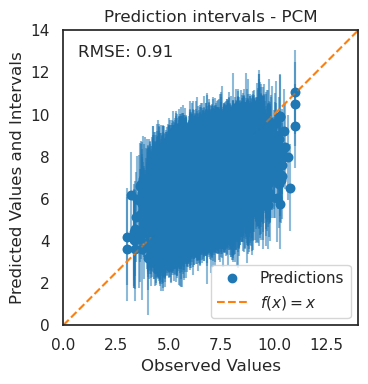

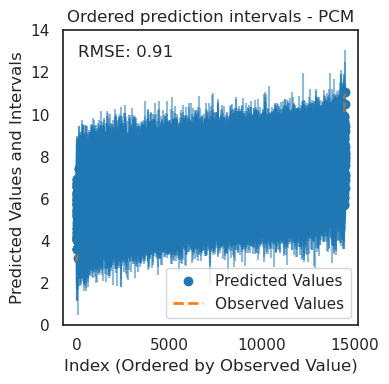

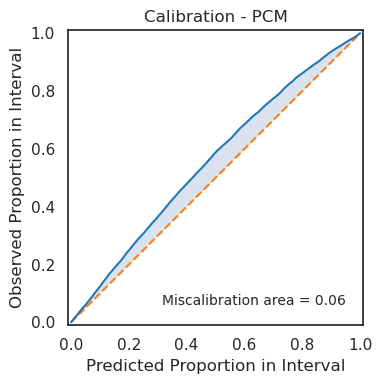

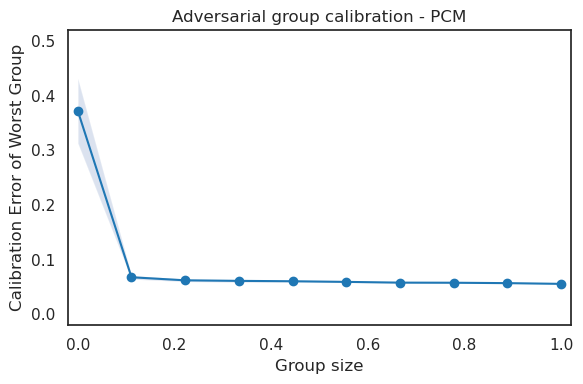

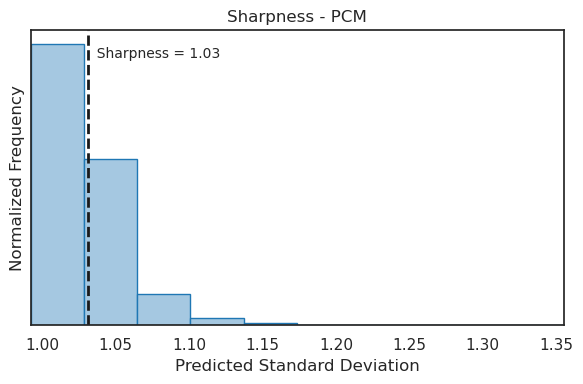

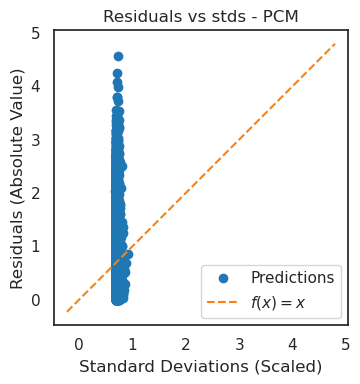

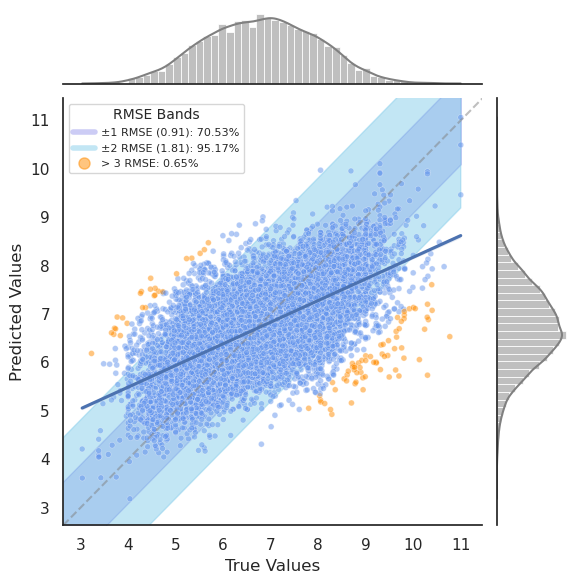

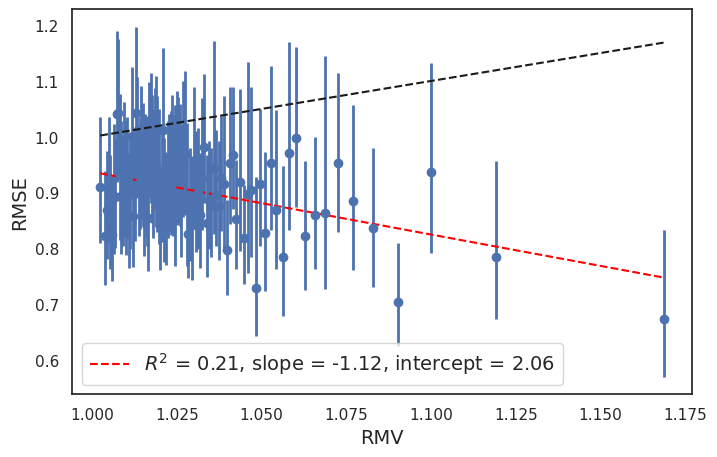

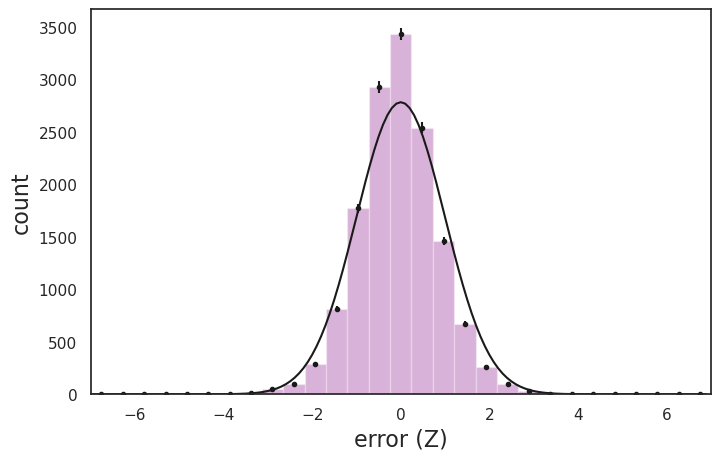

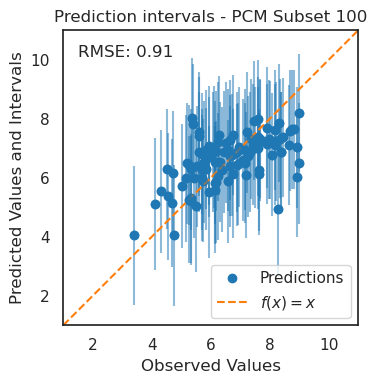

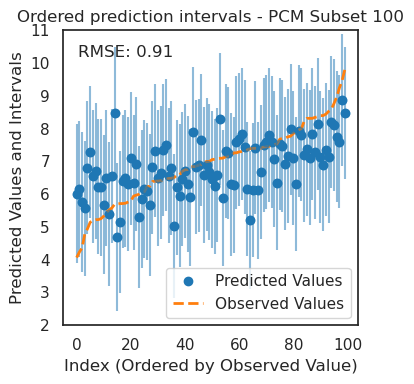

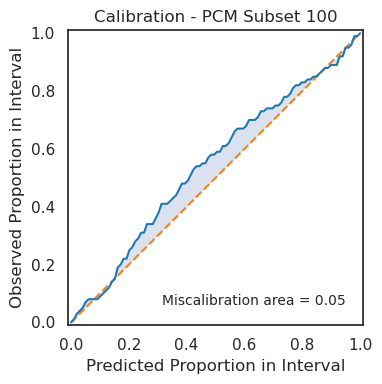

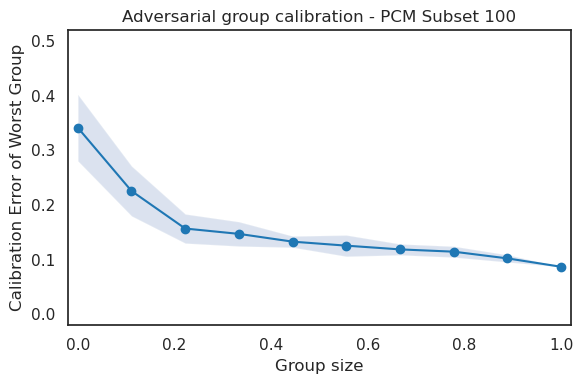

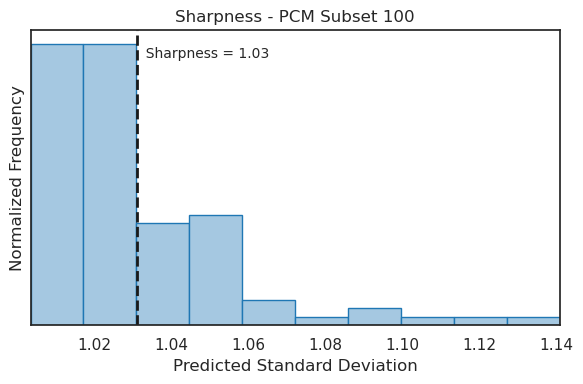

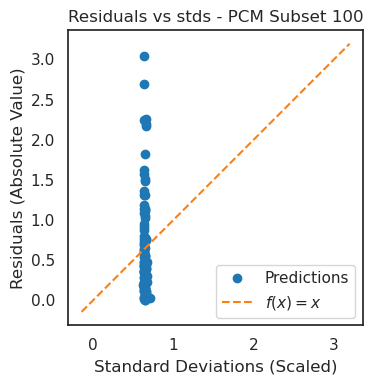

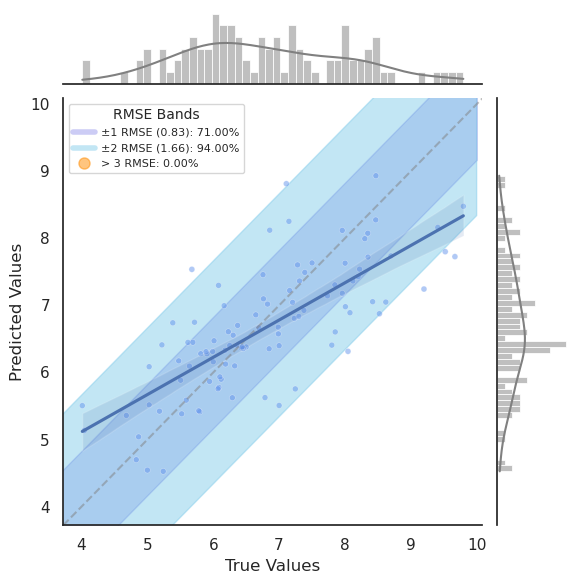

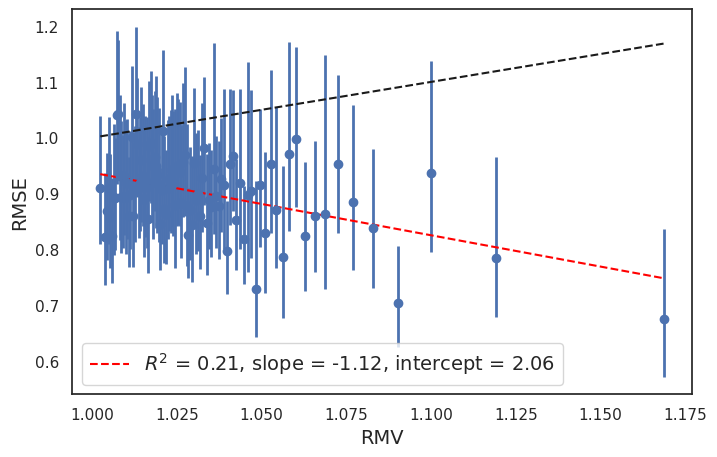

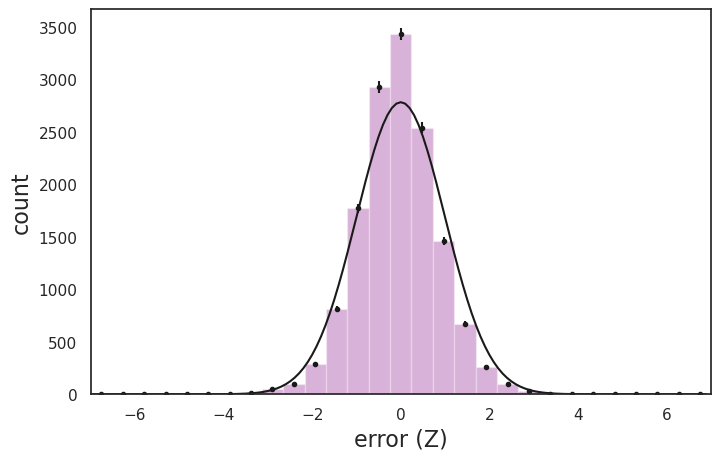

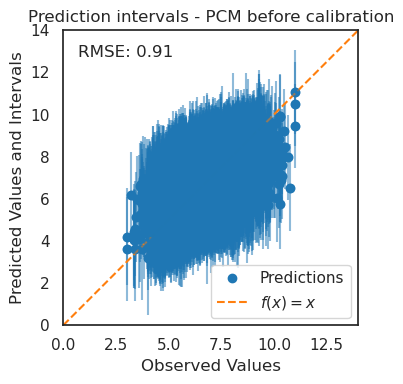

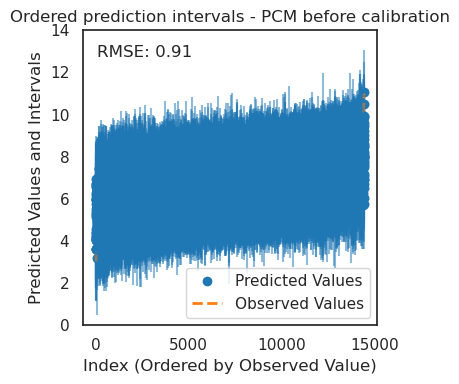

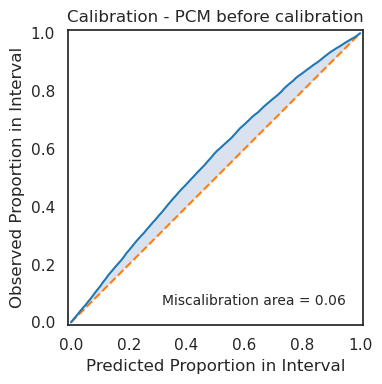

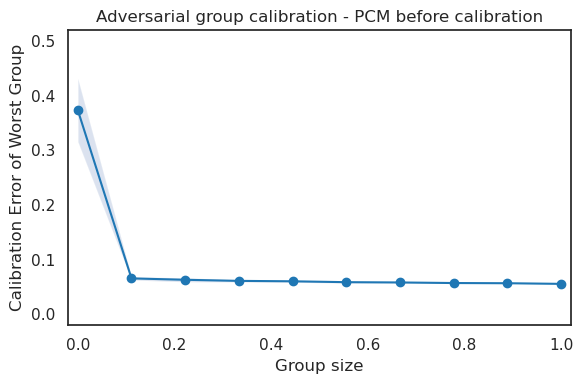

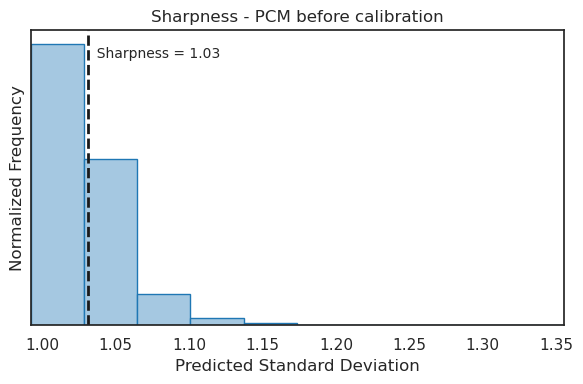

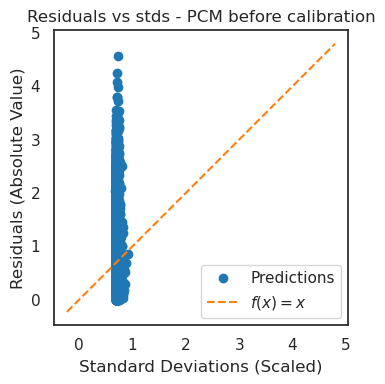

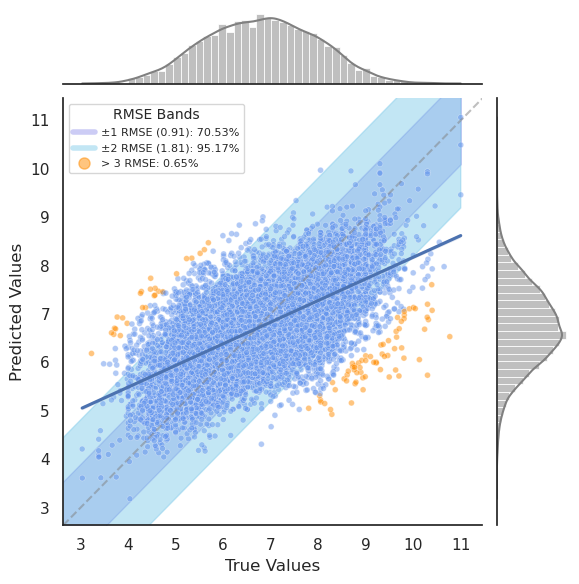

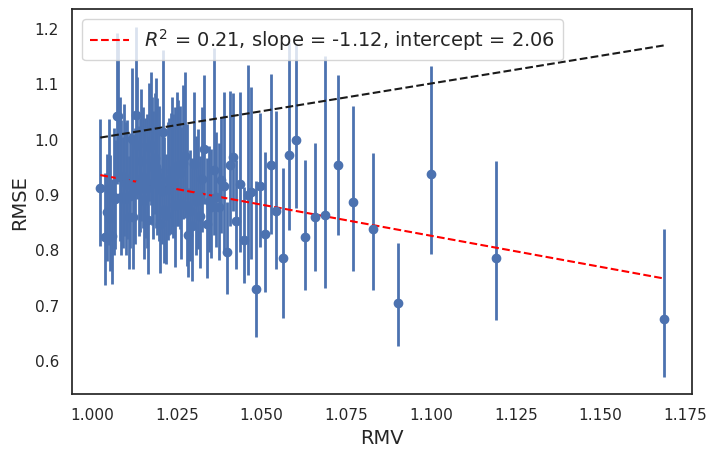

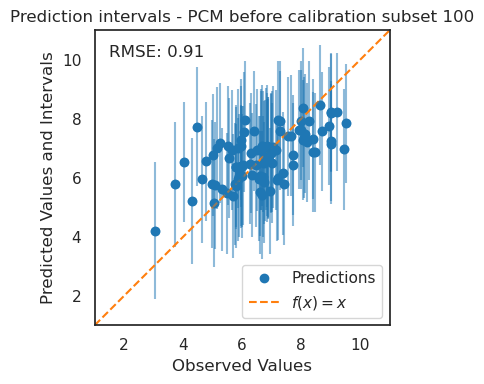

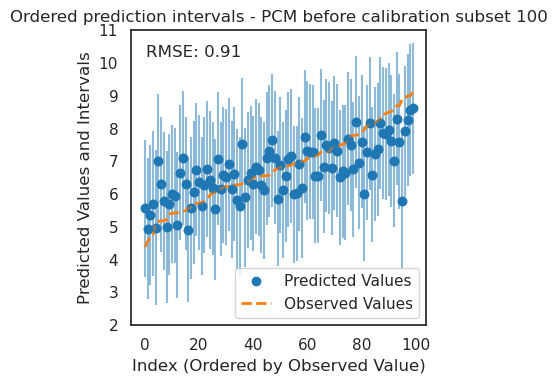

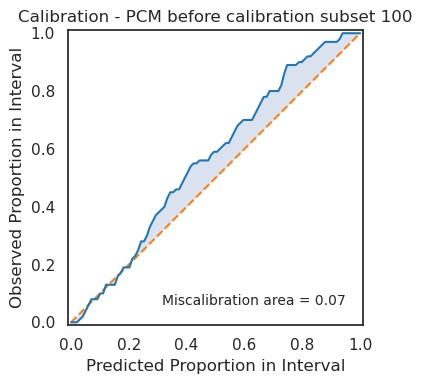

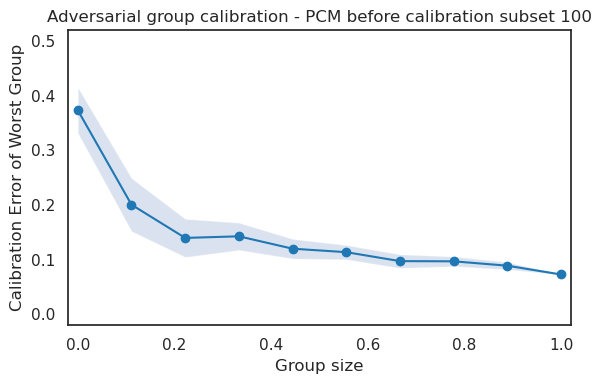

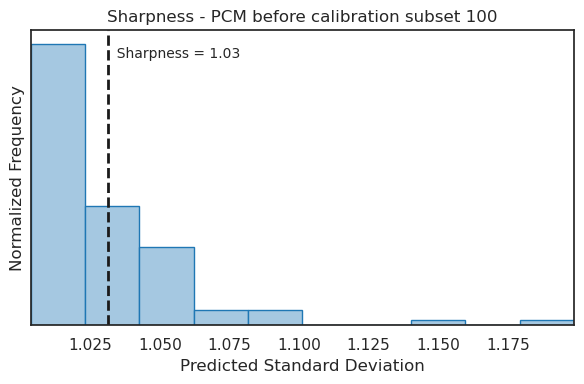

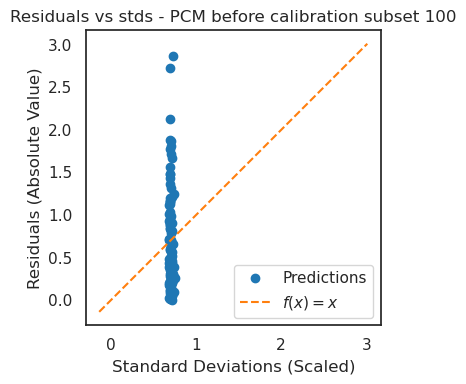

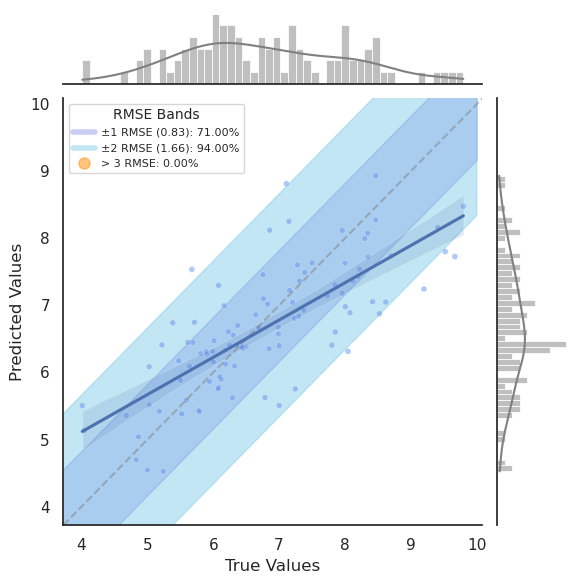

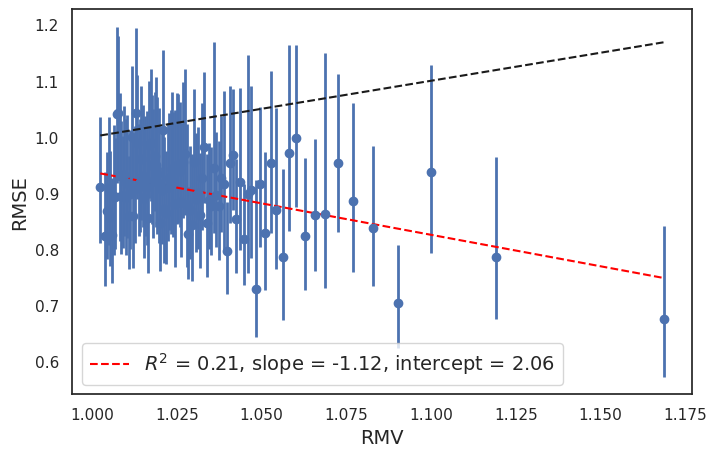

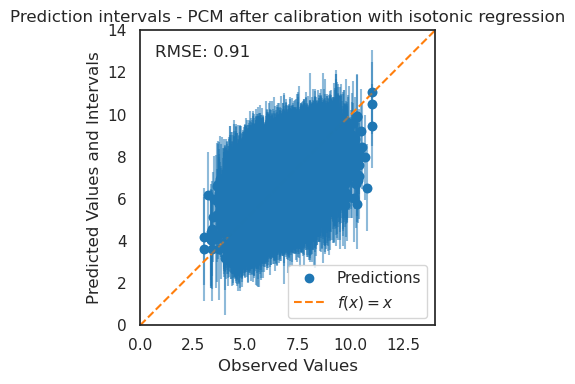

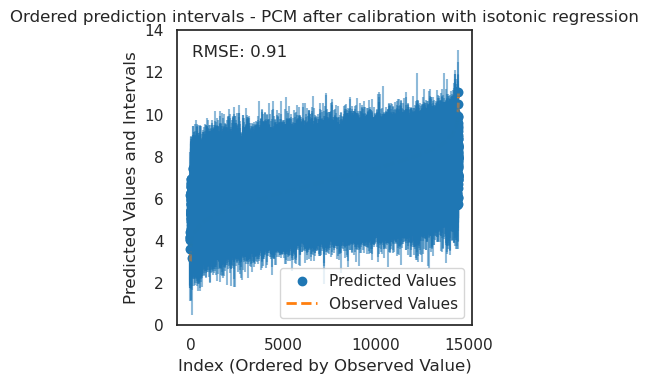

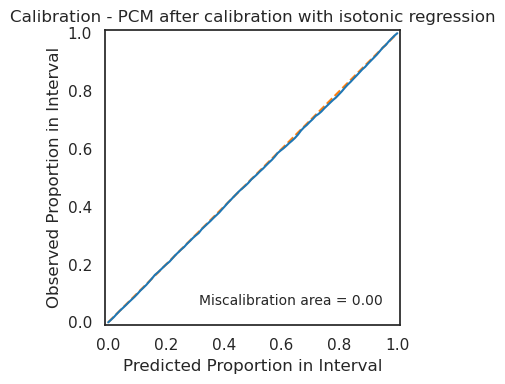

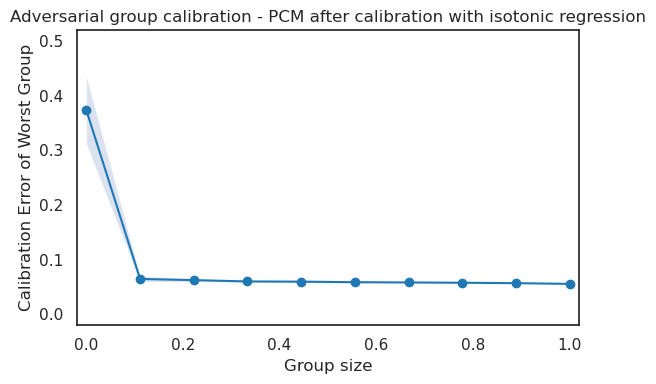

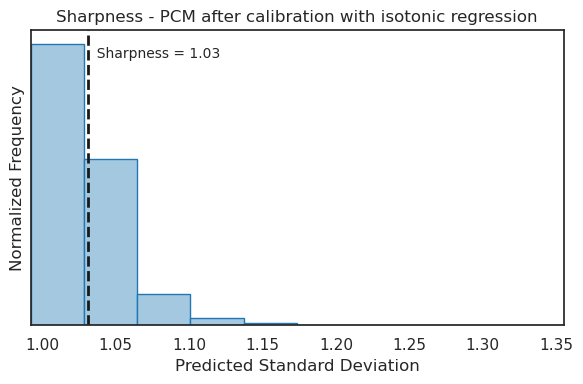

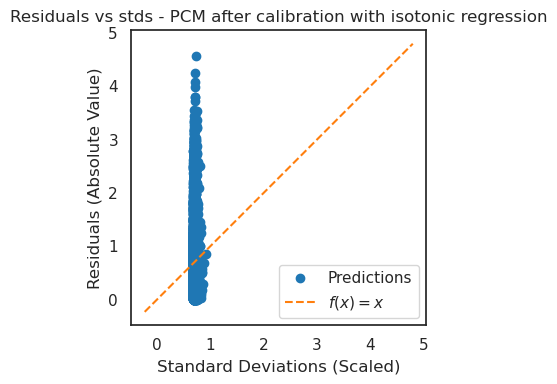

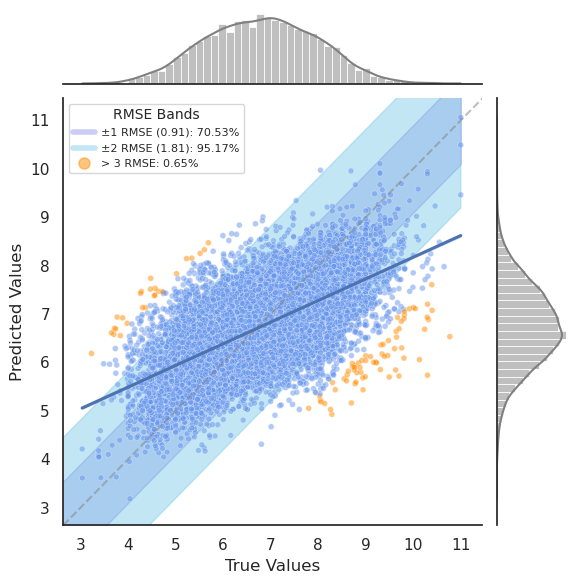

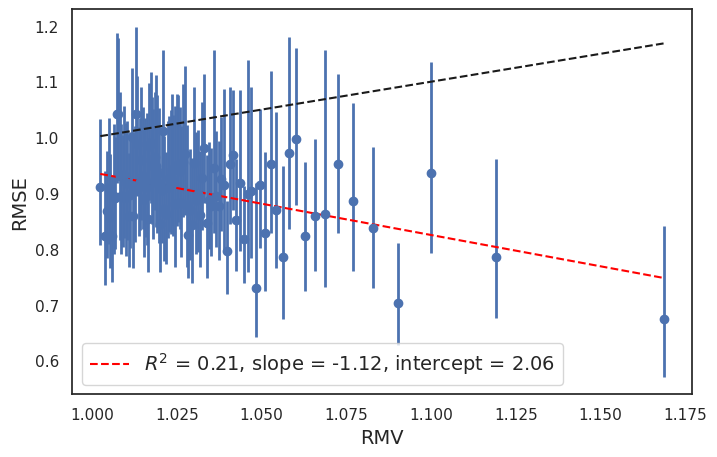

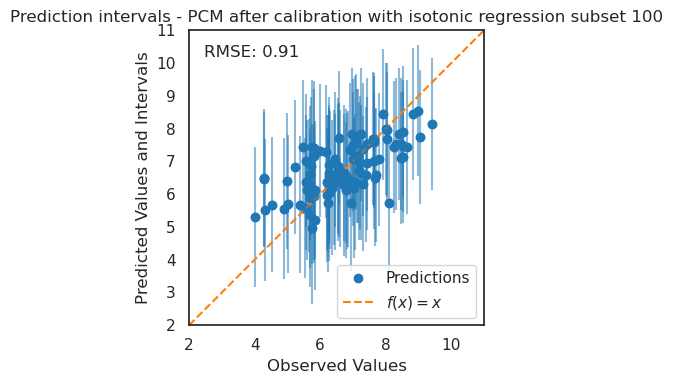

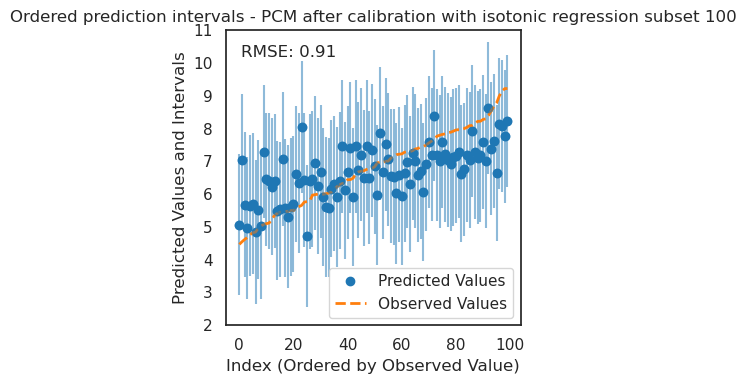

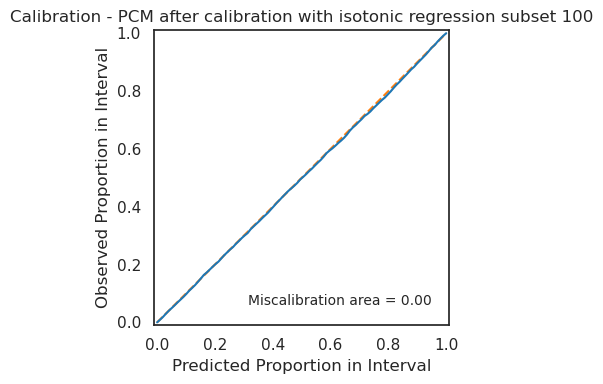

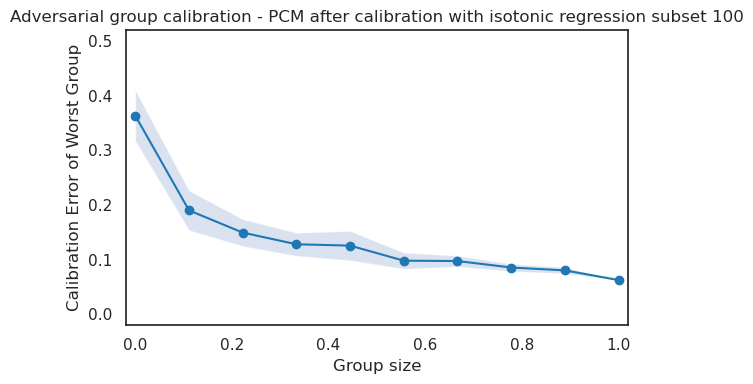

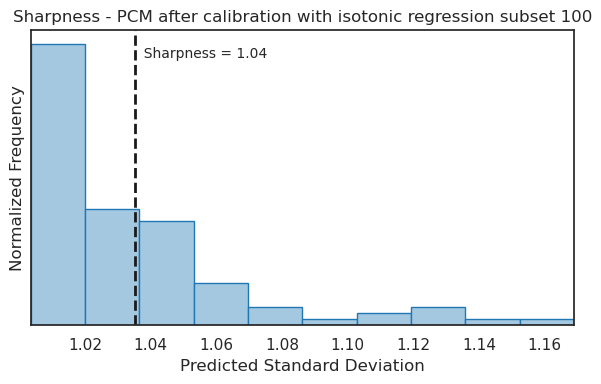

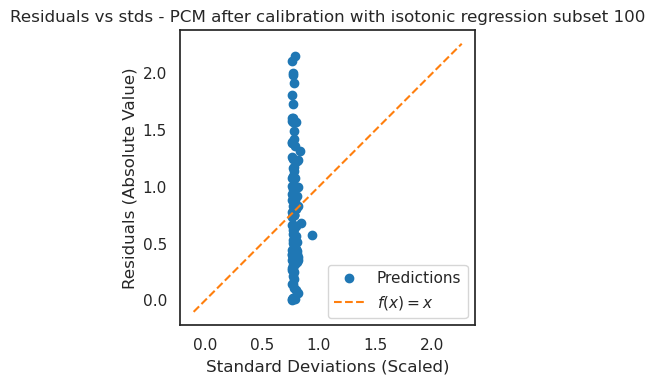

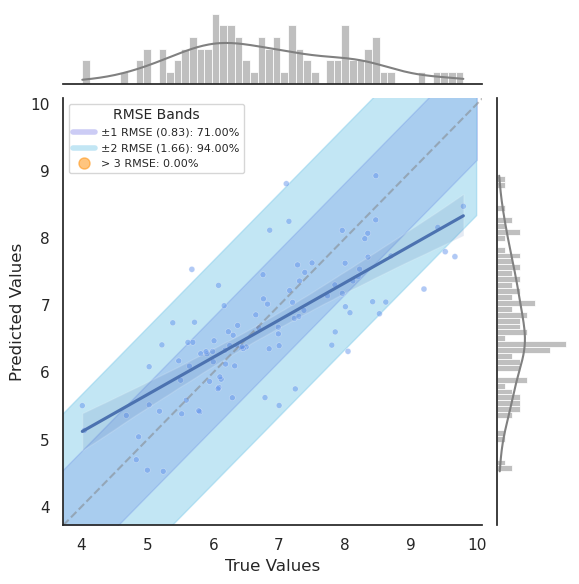

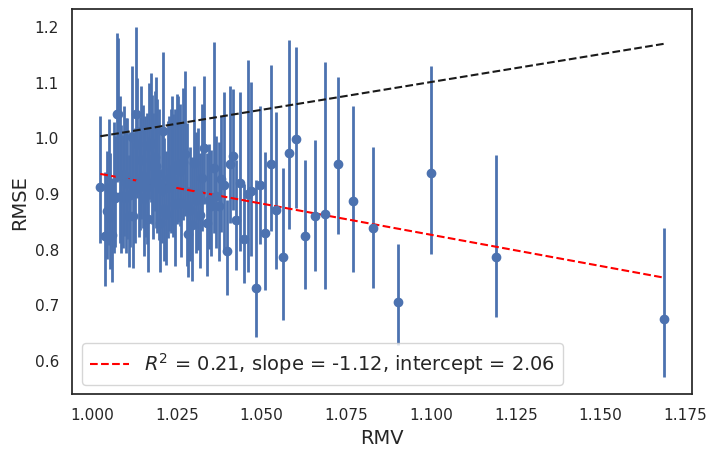

In [12]:
# Reassessing metrics and recalibration of the pretrained models
for index, row in runs_df.iterrows():
    if index != 1: # Debugging
        continue
    model_path = row['model_path']
    model_name = row['model_name']
    # print(type(model_path))
    rowkwargs = row.to_dict()
    # popping the model_type 
    model_type = rowkwargs.pop('model_type')

    if model_path:
        model_fig_out_path = os.path.join(figs_out_path, model_name)
        config = get_model_config(model_type=model_type, **rowkwargs)
        model_class = get_model_class(model_type)
        model = load_model(model_class, model_path, config=config).to(DEVICE)
        
        # Getting DataLoaders
        dataloaders = get_dataloader(config, device=DEVICE, logger=logger)
        
        # RePredict and Evaluate preds
        preds, labels, alea_vars, epi_vars = get_preds(model, dataloaders, model_type, subset='test')
        process_preds(preds, labels, alea_vars, epi_vars)
        # predict_fn, predict_kwargs = get_predict_fn(model_type)
        # print(predict_fn)
        
        # preds_res = predict_fn(model, dataloaders["test"], device=DEVICE, **predict_kwargs)

        # Calculate the metrics
        metrics, plots, uct_logger = evaluate_predictions(
            config, 
            preds, 
            labels, 
            alea_vars, 
            model_type, 
            logger, 
            epi_vars=epi_vars,
            wandb_push=False,
            run_name=config['run_name'], 
            project_name=project_out_name, # for the csv file
            figpath=model_fig_out_path, 
            export_preds=False, 
            verbose=False
        )
        
        # Recalibrate model
        preds_val, labels_val, alea_vars_val, epi_vars_val = get_preds(model, dataloaders, model_type, subset='val')
        # # Recalibration (Validation Set)
        # preds_val, labels_val, alea_vars_val = predict_fn(model, dataloaders["val"], device=DEVICE, **predict_kwargs)
        # 
        iso_recal_model = recalibrate_model(
            preds_val, 
            labels_val,
            alea_vars_val,
            preds, 
            labels, 
            alea_vars,
            config=config, 
            epi_val=epi_vars_val,
            epi_test=epi_vars,
            uct_logger=uct_logger,
            figpath=model_fig_out_path
        )
        
        # Log the metrics to the CSV file
        # uct_logger.csv_log()
        break
        

In [6]:
predict_kwargs

{'aleatoric': True, 'num_mc_samples': 100}

In [7]:
uct_logger.csv_log()

In [5]:
# Load csv runs and model names file
runs_df = load_df(runs_path, converters={'chem_layers': convert_to_list, 'prot_layers': convert_to_list, 'regressor_layers': convert_to_list})
runs_df.shape

(80, 18)

In [31]:
# runs_df.columns, runs_df.shape, runs_df.dtypes

In [7]:
runs_df.head()

,Name,State,Created,activity_type,chem_input_dim,chem_layers,descriptor_chemical,descriptor_protein,dropout,ensemble_size,lamb,lr,regressor_layers,prot_layers,prot_input_dim,model_type,model_name,split_type
0,devoted-sponge-82,running,2024-07-02T15:12:01.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.1,100,NaN,0.0005,[64],"[1024, 512, 256]",NaN,ensemble,NaN,random
1,leafy-wood-84,finished,2024-06-27T07:52:49.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,NaN,scaffold_cluster
2,cosmic-field-83,finished,2024-06-26T09:29:17.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,NaN,scaffold_cluster
3,fast-elevator-82,finished,2024-06-26T09:28:56.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,NaN,scaffold_cluster
4,noble-frost-81,finished,2024-06-26T09:28:53.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,NaN,scaffold_cluster


In [8]:
### Adding model_name
# date-{data_name}_{activity_type}_{split_type}_{descriptor_protein}_{descriptor_chemical}_{data_specific_path}_{run_name}
# 20240625-papyrus_xc50_mcdropout_random_ankh-large_ecfp2048_stoic-firebrand-80
# Fill missing model_name with the required format
runs_df['model_name'] = runs_df.apply(
    lambda row: f"papyrus_xc50_{row['model_type']}_{row['split_type']}_ankh-large_ecfp2048_{row['Name']}"
    if pd.isna(row['model_name']) else row['model_name'], axis=1)

In [9]:
runs_df.head()

,Name,State,Created,activity_type,chem_input_dim,chem_layers,descriptor_chemical,descriptor_protein,dropout,ensemble_size,lamb,lr,regressor_layers,prot_layers,prot_input_dim,model_type,model_name,split_type
0,devoted-sponge-82,running,2024-07-02T15:12:01.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.1,100,NaN,0.0005,[64],"[1024, 512, 256]",NaN,ensemble,papyrus_xc50_ensemble_random_ankh-large_ecfp20...,random
1,leafy-wood-84,finished,2024-06-27T07:52:49.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,papyrus_xc50_ensemble_scaffold_cluster_ankh-la...,scaffold_cluster
2,cosmic-field-83,finished,2024-06-26T09:29:17.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,papyrus_xc50_ensemble_scaffold_cluster_ankh-la...,scaffold_cluster
3,fast-elevator-82,finished,2024-06-26T09:28:56.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,papyrus_xc50_ensemble_scaffold_cluster_ankh-la...,scaffold_cluster
4,noble-frost-81,finished,2024-06-26T09:28:53.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,papyrus_xc50_ensemble_scaffold_cluster_ankh-la...,scaffold_cluster


In [10]:
# Update model_name
for index, row in runs_df.iterrows():
    model_name = row['model_name']
    model_file_pattern = os.path.join(models_dir, f"*{model_name}.pt")
    model_files = glob.glob(model_file_pattern)
    if model_files:
        model_file_path = model_files[0]
        model_name = os.path.basename(model_file_path).replace('.pt', '')
        # print(model_name)
        runs_df.at[index, 'model_name'] = model_name
        # add model_file_path to the runs_df
        runs_df.at[index, 'model_file_path'] = model_file_path
    else:
        print(model_file_pattern)
        print(model_files)

/users/home/bkhalil/Repos/uqdd/uqdd/models/saved_models/papyrus/xc50/all/*papyrus_xc50_ensemble_random_ankh-large_ecfp2048_devoted-sponge-82.pt
[]


In [11]:
runs_df.head(-5)

,Name,State,Created,activity_type,chem_input_dim,chem_layers,descriptor_chemical,descriptor_protein,dropout,ensemble_size,lamb,lr,regressor_layers,prot_layers,prot_input_dim,model_type,model_name,split_type,model_file_path
0,devoted-sponge-82,running,2024-07-02T15:12:01.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.1,100,NaN,0.0005,[64],"[1024, 512, 256]",NaN,ensemble,papyrus_xc50_ensemble_random_ankh-large_ecfp20...,random,NaN
1,leafy-wood-84,finished,2024-06-27T07:52:49.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,20240627-papyrus_xc50_ensemble_scaffold_cluste...,scaffold_cluster,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...
2,cosmic-field-83,finished,2024-06-26T09:29:17.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,20240626-papyrus_xc50_ensemble_scaffold_cluste...,scaffold_cluster,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...
3,fast-elevator-82,finished,2024-06-26T09:28:56.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,20240626-papyrus_xc50_ensemble_scaffold_cluste...,scaffold_cluster,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...
4,noble-frost-81,finished,2024-06-26T09:28:53.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],[512],NaN,ensemble,20240626-papyrus_xc50_ensemble_scaffold_cluste...,scaffold_cluster,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,light-sunset-9,finished,2024-06-25T14:11:29.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.1,100,NaN,0.0005,[64],"[1024, 512, 256]",NaN,ensemble,20240625-papyrus_xc50_ensemble_random_ankh-lar...,random,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...
71,laced-gorge-5,finished,2024-06-25T14:11:29.000Z,xc50,2048.0,[512],ecfp2048,ankh-large,0.2,100,NaN,0.0005,[64],"[1024, 512, 256]",1536.0,mcdropout,20240625-papyrus_xc50_mcdropout_random_ankh-la...,random,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...
72,peach-wave-9,finished,2024-06-25T14:11:29.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.1,100,NaN,0.0005,[64],"[1024, 512, 256]",NaN,ensemble,20240625-papyrus_xc50_ensemble_random_ankh-lar...,random,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...
73,avid-energy-14,finished,2024-06-25T14:11:29.000Z,xc50,NaN,[512],ecfp2048,ankh-large,0.1,100,NaN,0.0005,[64],"[1024, 512, 256]",NaN,ensemble,20240625-papyrus_xc50_ensemble_random_ankh-lar...,random,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...


In [12]:
runs_df['data_name'] = 'papyrus'
runs_df['activity_type'] = 'xc50'
runs_df['descriptor_protein'] = 'ankh-large'
runs_df['descriptor_chemical'] = 'ecfp2048'
runs_df['chem_input_dim'] = 2048
runs_df['prot_input_dim'] = 1536
runs_df['data_specific_path'] = 'papyrus/xc50/all'

In [13]:
runs_df.head()

,Name,State,Created,activity_type,chem_input_dim,chem_layers,descriptor_chemical,descriptor_protein,dropout,ensemble_size,...,lr,regressor_layers,prot_layers,prot_input_dim,model_type,model_name,split_type,model_file_path,data_name,data_specific_path
0,devoted-sponge-82,running,2024-07-02T15:12:01.000Z,xc50,2048,[512],ecfp2048,ankh-large,0.1,100,...,0.0005,[64],"[1024, 512, 256]",1536,ensemble,papyrus_xc50_ensemble_random_ankh-large_ecfp20...,random,NaN,papyrus,papyrus/xc50/all
1,leafy-wood-84,finished,2024-06-27T07:52:49.000Z,xc50,2048,[512],ecfp2048,ankh-large,0.2,100,...,0.0005,[64],[512],1536,ensemble,20240627-papyrus_xc50_ensemble_scaffold_cluste...,scaffold_cluster,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...,papyrus,papyrus/xc50/all
2,cosmic-field-83,finished,2024-06-26T09:29:17.000Z,xc50,2048,[512],ecfp2048,ankh-large,0.2,100,...,0.0005,[64],[512],1536,ensemble,20240626-papyrus_xc50_ensemble_scaffold_cluste...,scaffold_cluster,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...,papyrus,papyrus/xc50/all
3,fast-elevator-82,finished,2024-06-26T09:28:56.000Z,xc50,2048,[512],ecfp2048,ankh-large,0.2,100,...,0.0005,[64],[512],1536,ensemble,20240626-papyrus_xc50_ensemble_scaffold_cluste...,scaffold_cluster,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...,papyrus,papyrus/xc50/all
4,noble-frost-81,finished,2024-06-26T09:28:53.000Z,xc50,2048,[512],ecfp2048,ankh-large,0.2,100,...,0.0005,[64],[512],1536,ensemble,20240626-papyrus_xc50_ensemble_scaffold_cluste...,scaffold_cluster,/users/home/bkhalil/Repos/uqdd/uqdd/models/sav...,papyrus,papyrus/xc50/all


In [14]:
def get_model_class(model_type: str):
    if model_type.lower() in ['baseline', 'mcdropout']:
        model_class = BaselineDNN
    elif model_type.lower() == 'ensemble':
        model_class = EnsembleDNN
    elif model_type.lower() == 'evidential':
        model_class = EvidentialDNN
    else:
        raise ValueError(f"Model type {model_type} not recognized")
    return model_class


In [15]:
def get_predict_fn(model_type: str):
    if model_type.lower() == 'mcdropout':
        predict_fn = mc_predict
        predict_kwargs = {"aleatoric": True, "num_mc_samples": 100}
        
    elif model_type.lower() in ['ensemble', 'baseline']:
        predict_fn = predict
        predict_kwargs = {}
        
    elif model_type.lower() == 'evidential':
        predict_fn = ev_predict
        predict_kwargs = {}
    else:
        raise ValueError(f"Model type {model_type} not recognized")
    return predict_fn, predict_kwargs

In [16]:
logger = create_logger(
    name="reassess",
    file_level="info",
    stream_level="info",
)

In [17]:
type(runs_df.iloc[2]['chem_layers'])

list

In [18]:
runs_df.iloc[2] 

Name                                                     cosmic-field-83
State                                                           finished
Created                                         2024-06-26T09:29:17.000Z
activity_type                                                       xc50
chem_input_dim                                                      2048
chem_layers                                                        [512]
descriptor_chemical                                             ecfp2048
descriptor_protein                                            ankh-large
dropout                                                              0.2
ensemble_size                                                        100
lamb                                                                 NaN
lr                                                                0.0005
regressor_layers                                                    [64]
prot_layers                                        

In [51]:
runs_df.model_file_path.dtype

dtype('O')

In [78]:

        # else:
        #     yield None, None

In [79]:
# for x, y in get_model(runs_df):
#     print(x, y)
#     break

scaffold_cluster
EnsembleDNN(
  (models): ModuleList(
    (0-99): 100 x BaselineDNN(
      (chem_feature_extractor): Sequential(
        (0): Linear(in_features=2048, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
      (prot_feature_extractor): Sequential(
        (0): Linear(in_features=1536, out_features=512, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
      (regressor_or_classifier): Sequential(
        (0): Linear(in_features=1024, out_features=64, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
      )
      (output_layer): Linear(in_features=64, out_features=1, bias=True)
      (aleavar_layer): Sequential(
        (0): Linear(in_features=64, out_features=1, bias=True)
        (1): Softplus(beta=1, threshold=20)
      )
    )
  )
) {'model_type': 'ensemble', 'ensemble_size': 100, 'loss': 'gaussnll', 'aleatoric': True, 'chem_layers': [512], 'prot_layers': [512], 're

In [21]:
row = runs_df.iloc[20]  # FOR TESTING 20 mcdp 1 ensemble 30 evidential

run_name = row['Name']
model_type = row['model_type']
print(model_type)
split_type = row['split_type']
model_name = row['model_name']
model_path = row['model_file_path']
chem_input_dim = row['chem_input_dim']
prot_input_dim = row['prot_input_dim']
chem_layers = row['chem_layers']
print(f'{chem_layers=}')
prot_layers = row['prot_layers']
print(f'{prot_layers=}')
regressor_layers = row['regressor_layers']
print(f'{regressor_layers=}')

dropout = row['dropout']
lamb = row['lamb']
ensemble_size = row['ensemble_size']
lr = row['lr']

config = get_model_config(
    model_type=model_type,
    split_type=split_type,
    data_name="papyrus",
    activity_type="xc50",
    descriptor_protein="ankh-large",
    descriptor_chemical="ecfp2048",
    data_specific_path="papyrus/xc50/all",
    model_name=model_name,
    chem_input_dim=chem_input_dim,
    prot_input_dim=prot_input_dim,
    chem_layers=chem_layers,
    prot_layers=prot_layers,
    regressor_layers=regressor_layers,
    dropout=dropout,
    lr=lr,
    lamb=lamb,
    ensemble_size=ensemble_size,
)
if model_path:
    print(model_type)
    model_class = get_model_class(model_type)
    print(model_class)
    model = load_model(model_class, model_path, config=config).to(DEVICE)


mcdropout
chem_layers=[512]
prot_layers=[1024, 512, 256]
regressor_layers=[64]
random
mcdropout
<class 'uqdd.models.baseline.BaselineDNN'>


In [22]:
model

BaselineDNN(
  (chem_feature_extractor): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (prot_feature_extractor): Sequential(
    (0): Linear(in_features=1536, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
  )
  (regressor_or_classifier): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (aleavar_layer)

In [23]:
config['batch_size']

256

In [24]:
dataloaders = get_dataloader(config, device=DEVICE, logger=logger)
print(dataloaders.keys())
print(dataloaders["train"].dataset.__len__())
print(dataloaders["val"].dataset.__len__())
print(dataloaders["test"].dataset.__len__())
print(len(dataloaders["train"]))
print(len(dataloaders["val"]))
print(len(dataloaders["test"]))
len(dataloaders["train"].dataset.data)


dict_keys(['train', 'val', 'test'])
65744
14090
14088
257
56
56


65744

In [25]:
predict_fn, predict_kwargs = get_predict_fn(model_type)
print(predict_fn)
preds, labels, alea_vars = predict_fn(model, dataloaders["test"], device=DEVICE, **predict_kwargs)

<function mc_predict at 0x7f753f9ca840>


MC prediction: 100%|██████████| 56/56 [00:06<00:00,  8.17it/s]


In [26]:
print(preds.shape)
print(labels.shape)
print(alea_vars.shape)

torch.Size([14088, 1, 100])
torch.Size([14088, 1])
torch.Size([14088, 1, 100])


In [28]:
alea_vars

tensor([[[0.7307, 0.3945, 0.6131,  ..., 0.5341, 0.5556, 0.6580]],

        [[0.6529, 0.5739, 0.7269,  ..., 0.6640, 0.7137, 0.7284]],

        [[0.7788, 0.8474, 0.7605,  ..., 0.7620, 0.5077, 0.6401]],

        ...,

        [[0.4787, 0.4503, 0.6423,  ..., 0.4373, 0.6042, 0.5465]],

        [[0.4253, 0.4623, 0.5492,  ..., 0.4968, 0.3938, 0.4424]],

        [[0.6959, 0.5379, 0.4641,  ..., 0.6084, 0.4492, 0.6046]]])

In [29]:
figpath = FIGS_DIR / 'papyrus/xc50/all' / '2024-06-25-all-models-100-reassess' / model_name
print(figpath)
# figpath.mkdir(parents=True, exist_ok=True)

/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-25-all-models-100-reassess/20240625-papyrus_xc50_mcdropout_random_ankh-large_ecfp2048_balmy-tree-65


Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-25-all-models-100-reassess/20240625-papyrus_xc50_mcdropout_random_ankh-large_ecfp2048_balmy-tree-65/PCM_uct_prediction_intervals.png
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-25-all-models-100-reassess/20240625-papyrus_xc50_mcdropout_random_ankh-large_ecfp2048_balmy-tree-65/PCM_uct_prediction_intervals.svg
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-25-all-models-100-reassess/20240625-papyrus_xc50_mcdropout_random_ankh-large_ecfp2048_balmy-tree-65/PCM_uct_ordered_prediction_intervals.png
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-25-all-models-100-reassess/20240625-papyrus_xc50_mcdropout_random_ankh-large_ecfp2048_balmy-tree-65/PCM_uct_ordered_prediction_intervals.svg
Saved figure /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-25-all-models-100-reassess/20240625-papyru

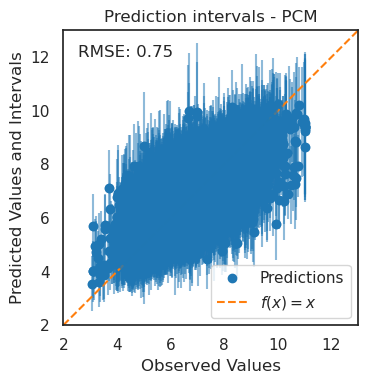

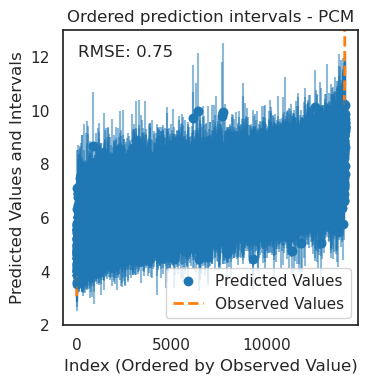

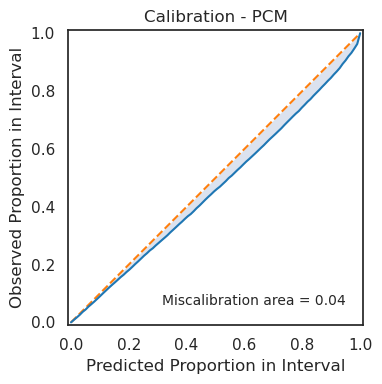

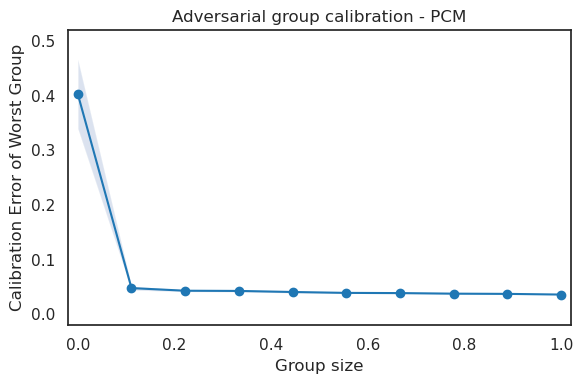

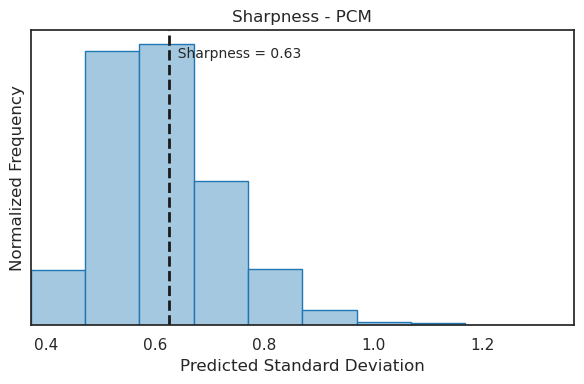

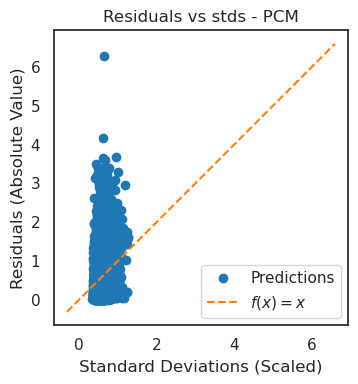

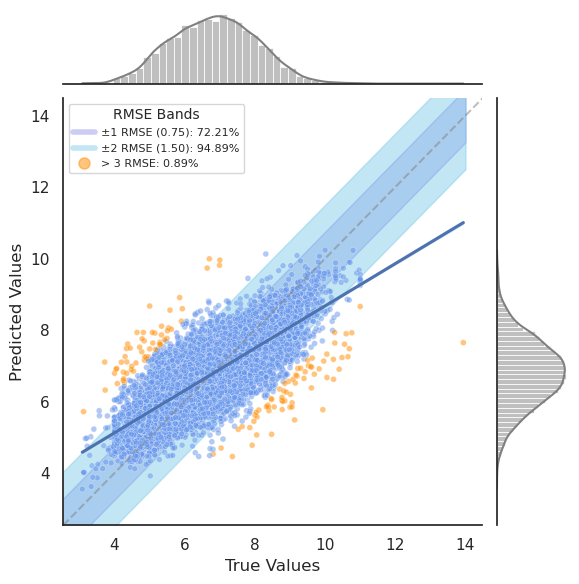

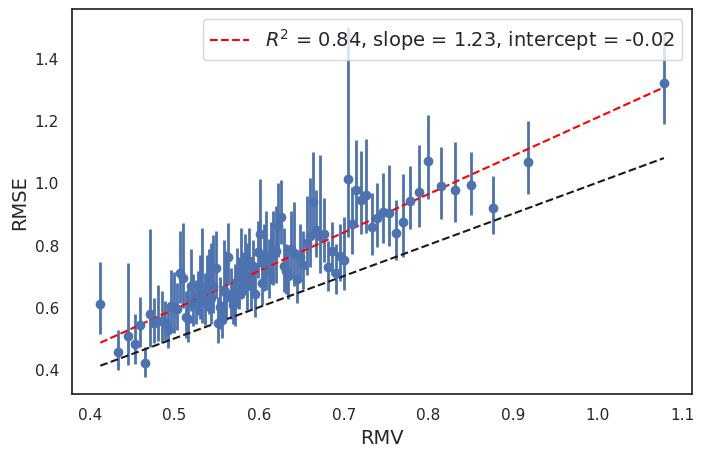

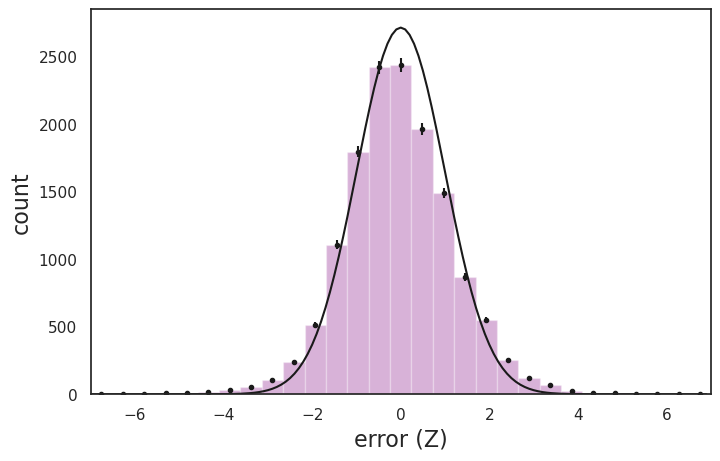

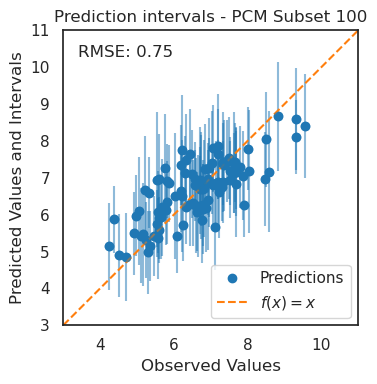

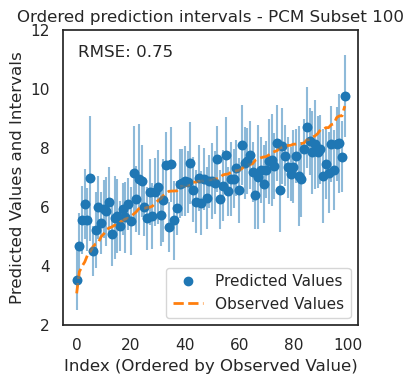

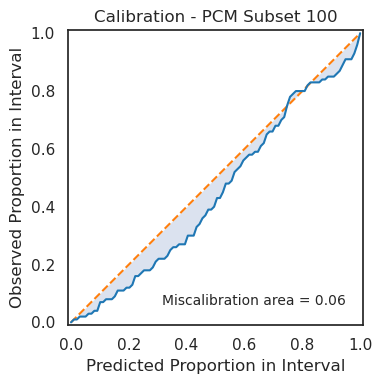

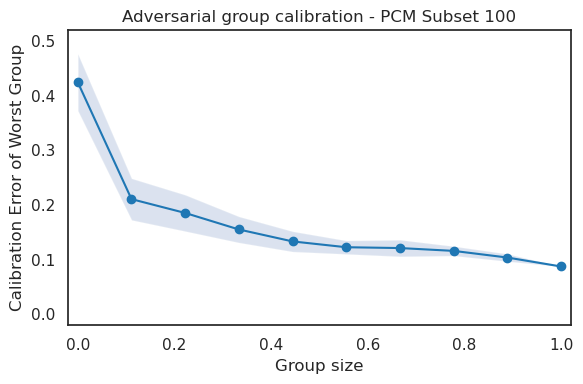

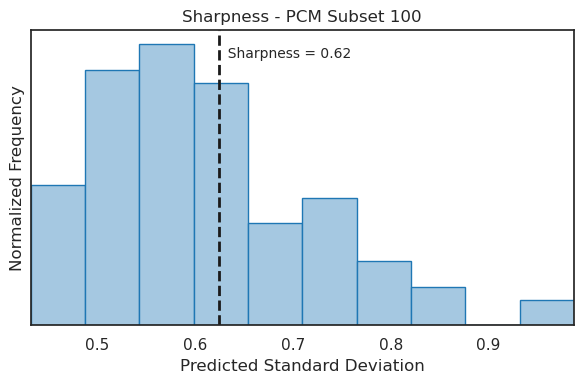

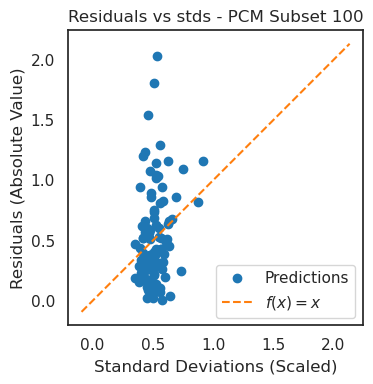

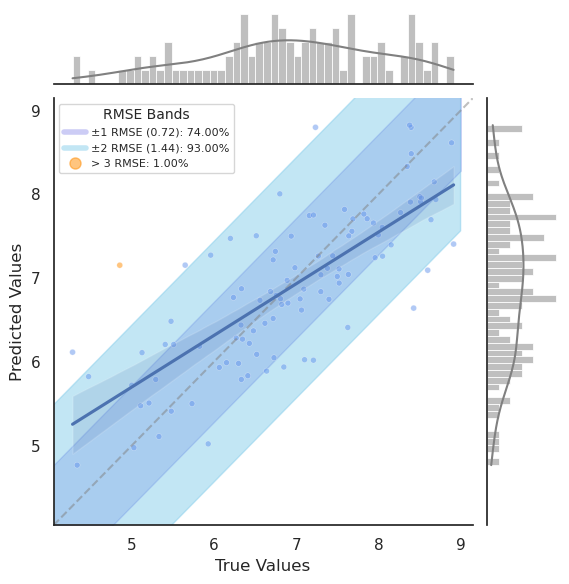

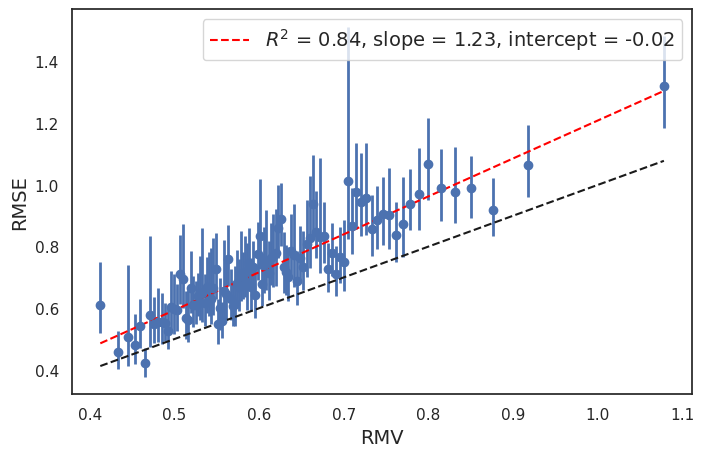

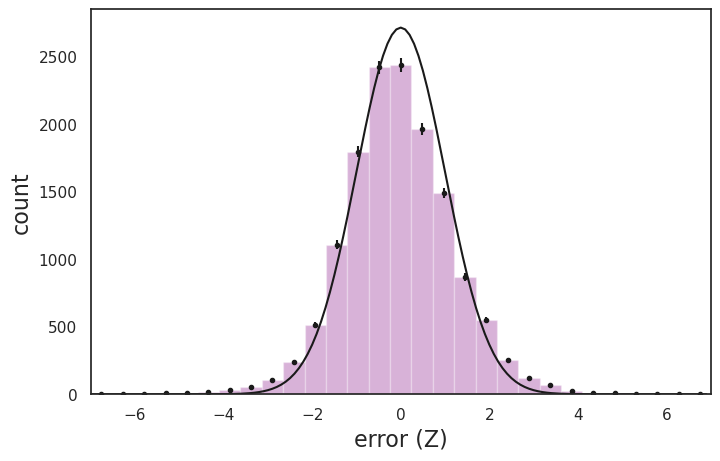

In [30]:

# Calculate the metrics
metrics, plots, uct_logger = evaluate_predictions(config, preds, labels, alea_vars, model_type, logger, run_name=run_name, project_name="test", figpath=figpath, export_preds=False, verbose=False)

In [ ]:
# Recalibrate model
preds_val, labels_val, alea_vars_val = predict(model, dataloaders["val"], device=DEVICE)
y_true_val, y_pred_val, y_std_val, y_err_val, y_alea_val = process_preds(
        preds_val, labels_val, alea_vars_val, epi_vars=None
    )

In [58]:
# Recalibrate model
preds_val, labels_val, alea_vars_val = predict(model, dataloaders["val"], device=DEVICE)
iso_recal_model = recalibrate_model(
        preds_val, 
        labels_val,
        alea_vars_val,
        preds, 
        labels, 
        alea_vars,
        config=config, 
        uct_logger=uct_logger,
        figpath=figpath
    )

Predicting: 100%|██████████| 27/27 [00:00<00:00, 176.66it/s]


IndexError: too many indices for tensor of dimension 1

In [28]:
# from uqdd.models.utils_metrics import process_preds
# 
# y_true_val, y_pred_val, y_std_val, y_err_val, y_alea_val = process_preds(
#         preds_val, labels_val,  epi_vars=None
#     )

# Final workflow
## 1. Preprocessing runs_df

In [33]:
y_alea_val.shape

(13742,)

In [20]:
# Iterate over each run in the runs.csv file
# i = 0
for index, row in runs_df.iterrows():
    run_name = row['Name']
    model_type = row['model_type']
    split_type = row['split_type']
    model_name = row['model_name']
    model_path = row['model_file_path']
    if model_path:
        print(model_type)
        model_class = get_model_class(model_type)
        model = load_model(model_class, model_path)
        config = get_model_config(
            model_type=model_type,
            split_type=split_type,
            data_name="papyrus",
            activity_type="xc50",
            descriptor_protein="ankh-large",
            descriptor_chemical="ecfp2048",
            data_specific_path="papyrus/xc50/all",
            model_name=model_name,
        )
        # Get dataloaders
        dataloaders = get_dataloader(config, device=DEVICE, logger=logger)
        print(dataloaders.keys())
        print(dataloaders["test"].dataset.__len__())
        print(f"Model: {model_name}")
        print(f"Model type: {model_type}")
        print(f"Split type: {split_type}")
        
        break        
        # # Generate predictions
        # preds, labels, alea_vars = predict(model, dataloaders["test"], device=DEVICE)
        # 
        # break
        
#     if not model_files:
#         print(model_file_pattern)
#         print(model_files)
#         i+=1
# print(i)
    # if index == 5:
    #     break

ensemble
random


TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got NoneType"

In [4]:
# Load predictions for each model_name
# predictions_path = 'predictions.csv'

filename = 'preds.csv'
predictions_df = load_df(preds_dirpath+filename)


FileNotFoundError: [Errno 2] No such file or directory: '/home/bkhalil/Repos/uqdd/uqdd/data/predictions/papyrus/xc50/all/preds.csv'

## Apply some fixes to runs.csv file
1. replace _ between scaffold_cluster with -
2. create the relevant model_name if not present (fixing a bug with ensemble)
3. match with file names after the date to avoid descripancies

In [ ]:
# Iterate over each run in the runs.csv file
for index, row in runs_df.iterrows():
    run_name = row['Name']
    model_type = row['model_type']
    split_type = row['split_type']
    model_name = row['model_name']
    
    model_file_path = os.path.join(models_dir, f"{model_name}.pt")
    
    if os.path.exists(model_file_path):
        
        
        model = load_model(model_class, model_file_path)
        
        # Create the model configuration
        config = get_model_config(
            model_type=model_type,
            data_name="papyrus",
            activity_type="xc50",
            split_type=split_type,
            descriptor_protein="ankh-large",
            descriptor_chemical="ecfp2048",
            data_specific_path="papyrus/xc50/all"
        )
        
        # Get dataloaders
        dataloaders = get_dataloader(config, device=DEVICE, logger=LOGGER)
        
        # Generate predictions
        preds, labels, alea_vars = predict(model, dataloaders["test"], device=DEVICE)
        
        # Calculate the metrics
        metrics, plots, uct_logger = evaluate_predictions(config, preds, labels, alea_vars, model_type, LOGGER)
        
        # Recalibrate model
        preds_val, labels_val, alea_vars_val = predict(model, dataloaders["val"], device=DEVICE)
        iso_recal_model, std_recal = recalibrate_model(preds_val, labels_val, preds, labels, config, uct_logger=uct_logger)
        
        # Log the metrics to the CSV file
        uct_logger.csv_log()

In [ ]:
dataloaders = get_dataloader(config, device=DEVICE, logger=LOGGER)

preds, labels, alea_vars = predict(
    ensemble_model, dataloaders["test"], device=DEVICE
)
# Then comes the predict metrics part
metrics, plots, uct_logger = evaluate_predictions(
    config, preds, labels, alea_vars, "mcdropout", LOGGER
)

# RECALIBRATION # Get Calibration / Validation Set # This predict is changeable according to function
preds_val, labels_val, alea_vars_val = predict(
    ensemble_model, dataloaders["val"], device=DEVICE
)
iso_recal_model, std_recal = recalibrate_model(
    preds_val, labels_val, preds, labels, config_, uct_logger=uct_logger
)



In [1]:

# get arrays from df cols
y_true = predictions_df['y_true'].values
y_pred = predictions_df['y_pred'].values
y_err = predictions_df['y_err'].values
y_alea = predictions_df['y_alea'].values
eps_col = 'y_std' if 'y_std' in predictions_df.columns else 'y_eps'
y_eps = predictions_df[eps_col].values

# we need to get model_type and config from runs_df
model_type = "ensemble"

config = get_model_config(
    model_type,
    data_name="papyrus",
    activity_type="xc50",
    split_type="random",
    descriptor_protein="ankh-large",
    descriptor_chemical="ecfp2048",
    data_specific_path="papyrus/xc50/all"
)


uct_metrics_logger = MetricsTable(
    model_type=model_type,
    config=config,
    add_plots_to_table=False,
    # * we can turn on if we want to see them in wandb * #
    # logger=logger,
    project_name=None, # to change as this will become the output csv file name
    run_name=None, # that would be the same run name from the runs.csv file
)
task_name = "PCM"
metrics, plots = uct_metrics_logger(
        y_pred=y_pred,
        y_std=y_alea,
        y_true=y_true,
        y_err=y_err,
        # y_alea=y_alea,
        y_eps=y_eps,
        task_name=task_name,
        figpath=None, # Here we need to define the fig path 
        # the figpath default was FIGS_DIR / data_specific_path / self.model_name
        # we can change it to mark the reassessment of the model somehoe (maybe add a prefix to model_name like reasses)
        # FIGS_DIR is imported variable from uqdd
        # data_specific_path is predefined var data_specific_path="papyrus/xc50/all"
    )

# * calculate metrics for a subset of the datapoints * #
submetrics, subplots = uct_metrics_logger(
    y_pred=y_pred,
    y_std=y_alea,
    y_true=y_true,
    y_err=y_err,
    # y_alea=y_alea,
    y_eps=y_eps,
    task_name=task_name+" Subset",
    n_subset=100,
)

# then we log to the csv file which appends after each iteration
uct_metrics_logger.csv_log()


NameError: name 'predictions_df' is not defined